In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import Counter
import pickle
import igraph as ig
import partition_igraph
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI


# Properties of ABCD

The following experiments were used to generate the Figures and Tables in:
```
Bogumił Kamiński, Bartosz Pankratz, Paweł Prałat and François Théberge,
Modularity of the ABCD Random Graph Model with Community Structure.
```

Results were obtained with the CLI version of ABCD from: https://github.com/bkamins/ABCDGraphGenerator.jl
Adjust the path below to your local version of the code.


In [2]:
abcd_path = '~/ABCD/utils/'

## Figure 1 - Cumulative degree distribution

With number of nodes: $n$=1,000 and $n$=1,000,000

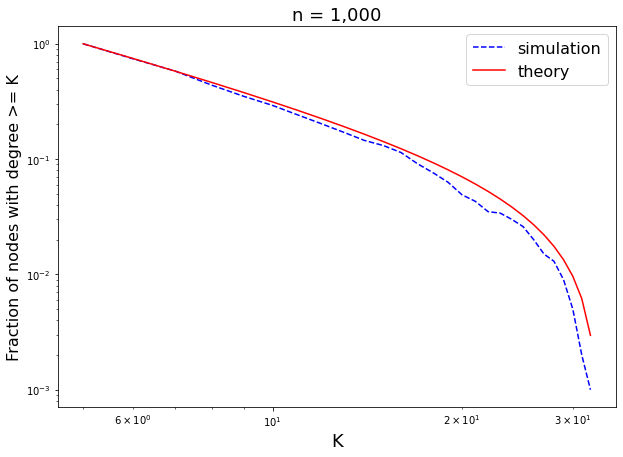

In [3]:
gamma = 2.5
delta = 5  
n = 1000
D = int(np.round(n**0.5))

cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
os.system(cmd+' >/dev/null 2>&1')
x = np.array(pd.read_csv('deg.dat',header=None)[0])

C = Counter(x)
cdf = np.zeros(D+1)
ctr = 0
for i in np.arange(D,delta-1,-1):
    ctr += C[i]
    cdf[i] = ctr
th = [ (k**(1-gamma) - (D+1)**(1-gamma)) / (delta**(1-gamma) - (D+1)**(1-gamma)) for k in np.arange(delta,D+1)]

plt.figure(figsize=(10,7))
plt.loglog(np.arange(delta,D+1),(cdf[delta:]/n),'b--',label='simulation')
plt.loglog(np.arange(delta,D+1),th,'r-',label='theory')
plt.xlabel('K', fontsize=18)
plt.ylabel('Fraction of nodes with degree >= K', fontsize=16)
plt.title('n = 1,000',fontsize=18)
plt.legend(fontsize=16);
#plt.savefig('degree_1k.pdf');

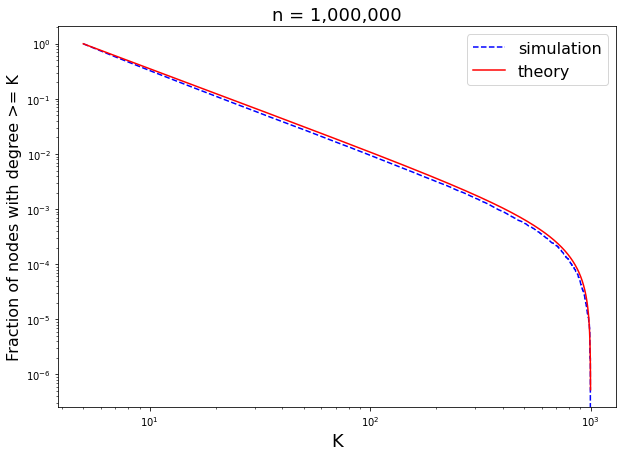

In [4]:
gamma = 2.5
delta = 5  
n = 1000000
D = int(np.round(n**0.5))

cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
os.system(cmd+' >/dev/null 2>&1')
x = np.array(pd.read_csv('deg.dat',header=None)[0])

C = Counter(x)
cdf = np.zeros(D+1)
ctr = 0
for i in np.arange(D,delta-1,-1):
    ctr += C[i]
    cdf[i] = ctr
th = [ (k**(1-gamma) - (D+1)**(1-gamma)) / (delta**(1-gamma) - (D+1)**(1-gamma)) for k in np.arange(delta,D+1)]

plt.figure(figsize=(10,7))
plt.loglog(np.arange(delta,D+1),(cdf[delta:]/n),'b--',label='simulation')
plt.loglog(np.arange(delta,D+1),th,'r-',label='theory')
plt.xlabel('K', fontsize=18)
plt.ylabel('Fraction of nodes with degree >= K', fontsize=16)
plt.title('n = 1,000,000',fontsize=18)
plt.legend(fontsize=16);
#plt.savefig('degree_1M.pdf');


## Figure 2 - Normalized average volume

We generate 100 graphs both with $\delta$ = 5 and $\delta$ = 25.

With that many repeats, the code below can take a while to complete (45 min on a Mac Pro),
so we illustrate the result with 10 repeats below.


In [5]:
## continuous model
def qk(k,gamma,delta,D):
    v = (k**(1-gamma) - (k+1)**(1-gamma)) / (delta**(1-gamma) - (D+1)**(1-gamma))
    return v
## discrete model
def rk(k,gamma):
    return k**(-gamma)

In [6]:
REP = 10 ## we used 100 repeats in the paper

gamma = 2.5
delta = 5
N = [1000*(2**i) for i in np.arange(16)]
X = []
S = []
d = []
r = []
for n in N:
    D = int(np.round(n**0.5))
    z = []
    for i in range(REP):
        cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
        os.system(cmd+' >/dev/null 2>&1')
        x = np.array(pd.read_csv('deg.dat',header=None)[0])
        z.append(sum(x)/n)
    X.append(np.mean(z))
    S.append(np.std(z))
    ## theory
    th = 0
    for k in np.arange(delta,D+1):
        th += (k*qk(k,gamma,delta,D))
    d.append(th)
    ## discrete
    th = 0
    s = 0
    for k in np.arange(delta,D+1):
        x = rk(k,gamma)
        th += (k*x)
        s += x        
    r.append(th/s)  
## optional - save a local copy of the results
#pickle.dump( (X, S, d, r), open( "./Data/degree_ratio_5.pkl", "wb" ) )


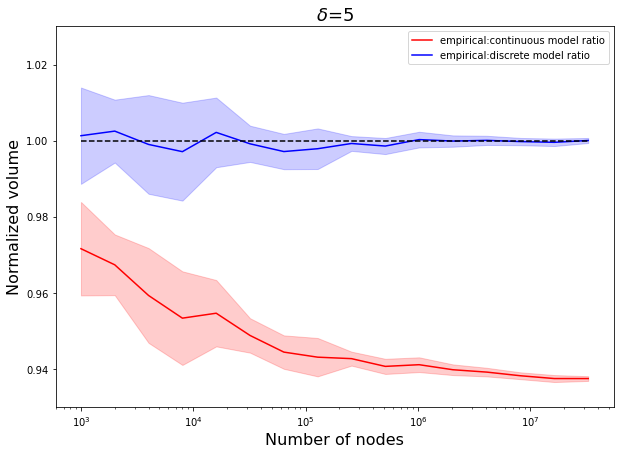

In [7]:
## optional - load a local copy of the results 
#X, S, d ,r = pickle.load( open( "./Data/degree_ratio_5.pkl", "rb" ) )

N = [1000*(2**i) for i in np.arange(16)]

plt.figure(figsize=(10,7))

Y = np.array([i/j for i,j in zip(X,d)])
err = np.array([i/j for i,j in zip(S,d)])
plt.semilogx(N, Y, 'r-',label='empirical:continuous model ratio')
plt.fill_between(N, Y-err, Y+err, color='red', alpha=.2)

Y = [i/j for i,j in zip(X,r)]
err = np.array([i/j for i,j in zip(S,r)])
plt.semilogx(N, Y, 'b-',label='empirical:discrete model ratio')
plt.fill_between(N, Y-err, Y+err, color='blue', alpha=.2)

plt.hlines(y=1,xmin=min(N),xmax=max(N),colors='black',linestyles='dashed')
plt.title(r"$\delta$=5", fontsize=18)
plt.xlabel('Number of nodes', fontsize=16)
plt.ylabel('Normalized volume', fontsize=16)
plt.ylim((.93,1.03))
plt.legend();
#plt.savefig('degree_ratio_5.pdf');

In [8]:
REP = 10 ## we used 100 repeats in the paper

gamma = 2.5
delta = 25

N = [1000*(2**i) for i in np.arange(16)]
X = []
S = []
d = []
r = []

for n in N:
    D = int(np.round(n**0.5))
    z = []
    for i in range(REP):
        cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
        os.system(cmd+' >/dev/null 2>&1')
        x = np.array(pd.read_csv('deg.dat',header=None)[0])
        z.append(sum(x)/n)
    X.append(np.mean(z))
    S.append(np.std(z))
    ## theory
    th = 0
    for k in np.arange(delta,D+1):
        th += (k*qk(k,gamma,delta,D))
    d.append(th)
    ## discrete
    th = 0
    s = 0
    for k in np.arange(delta,D+1):
        x = rk(k,gamma)
        th += (k*x)
        s += x        
    r.append(th/s)
    
## optional - save a local copy of the results
#pickle.dump( (X, S, d, r), open( "./Data/degree_ratio_25.pkl", "wb" ) )


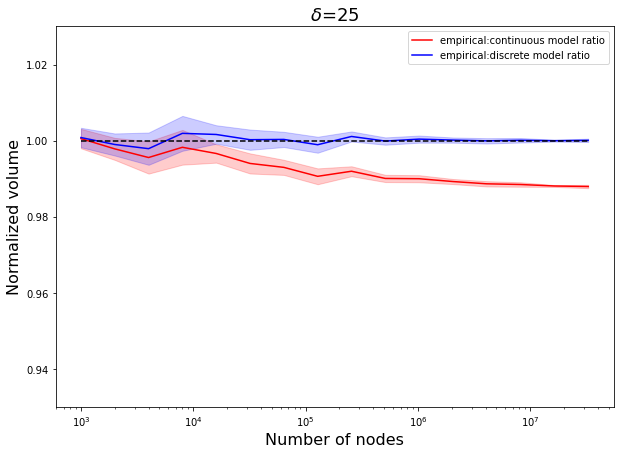

In [9]:
## optional - load a local copy of the results - uncomment the cell above to (re-)generate
#X, S, d ,r = pickle.load( open( "./Data/degree_ratio_25.pkl", "rb" ) )
N = [1000*(2**i) for i in np.arange(16)]

plt.figure(figsize=(10,7))

Y = np.array([i/j for i,j in zip(X,d)])
err = np.array([i/j for i,j in zip(S,d)])
plt.semilogx(N, Y, 'r-',label='empirical:continuous model ratio')
plt.fill_between(N, Y-err, Y+err, color='red', alpha=.2)

Y = [i/j for i,j in zip(X,r)]
err = np.array([i/j for i,j in zip(S,r)])
plt.semilogx(N, Y, 'b-',label='empirical:discrete model ratio')
plt.fill_between(N, Y-err, Y+err, color='blue', alpha=.2)

plt.hlines(y=1,xmin=min(N),xmax=max(N),colors='black',linestyles='dashed')
plt.title(r"$\delta$=25", fontsize=18)
plt.xlabel('Number of nodes', fontsize=16)
plt.ylabel('Normalized volume', fontsize=16)
## un-comment to force the same y-range as previous plot
plt.ylim((.93,1.03))
plt.legend();
plt.savefig('degree_ratio_25.pdf');

## Figure 3 - Cumulative community size distribution

Again with $n$=1,000 and $n$=1,000,000.

With 30 repeats, the experiment with small graphs of size 1,000 has noticeable variability.


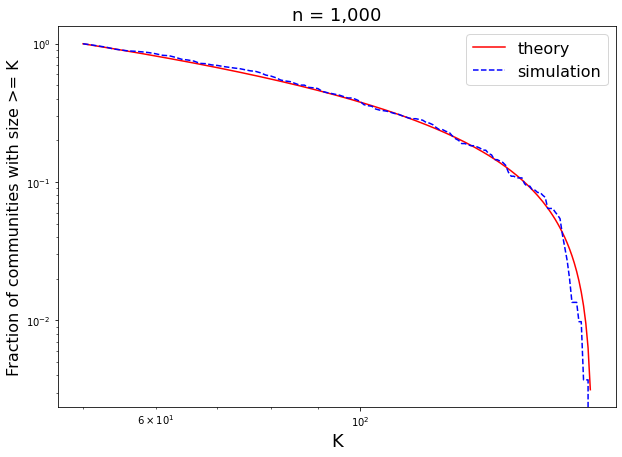

In [10]:
beta = 1.5
s = 50 
n = 1000
S = int(np.round(n**0.75))

th = [ (k**(1-beta) - (S+1)**(1-beta)) / (s**(1-beta) - (S+1)**(1-beta)) for k in np.arange(s,S+1)]
REP = 30
cdf = np.zeros(S+1)

for rep in range(REP):
    cmd = 'julia '+abcd_path+'com_sampler.jl comm.dat '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000'
    os.system(cmd+' >/dev/null 2>&1')
    x = np.array(pd.read_csv('comm.dat',header=None)[0])

    C = Counter(x)
    nc = len(x) ## NEW 
    ctr = 0
    for i in np.arange(S,s-1,-1):
        ctr += C[i]
        cdf[i] += ctr/nc ## NEW
for i in np.arange(S,s-1,-1): 
    cdf[i] /= REP

## plot    
plt.figure(figsize=(10,7))
plt.loglog(np.arange(s,S+1),th,'r-',label='theory')
plt.loglog(np.arange(s,S+1),(cdf[s:]),'b--',label='simulation')
plt.xlabel('K', fontsize=18)
plt.ylabel('Fraction of communities with size >= K', fontsize=16)
plt.title('n = 1,000',fontsize=18)
plt.legend(fontsize=16);
# plt.savefig('comm_1k.pdf');

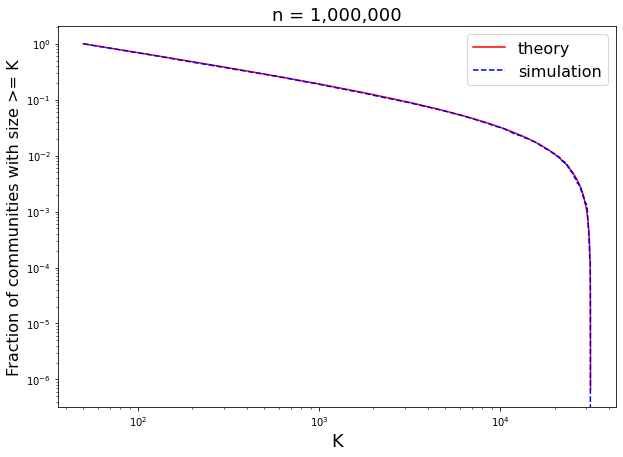

In [11]:
beta = 1.5
s = 50 
n = 1000000
S = int(np.round(n**0.75))

th = [ (k**(1-beta) - (S+1)**(1-beta)) / (s**(1-beta) - (S+1)**(1-beta)) for k in np.arange(s,S+1)]
REP = 30
cdf = np.zeros(S+1)

for rep in range(REP):
    cmd = 'julia '+abcd_path+'com_sampler.jl comm.dat '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000'
    os.system(cmd+' >/dev/null 2>&1')
    x = np.array(pd.read_csv('comm.dat',header=None)[0])

    C = Counter(x)
    nc = len(x) ## NEW 
    ctr = 0
    for i in np.arange(S,s-1,-1):
        ctr += C[i]
        cdf[i] += ctr/nc ## NEW
for i in np.arange(S,s-1,-1): 
    cdf[i] /= REP

## plot
plt.figure(figsize=(10,7))
plt.loglog(np.arange(s,S+1),th,'r-',label='theory')
plt.loglog(np.arange(s,S+1),(cdf[s:]),'b--',label='simulation')
plt.xlabel('K', fontsize=18)
plt.ylabel('Fraction of communities with size >= K', fontsize=16)
plt.title('n = 1,000,000',fontsize=18)
plt.legend(fontsize=16);
#plt.savefig('comm_1M.pdf');

## Figure 4 - Number of communities

We consider 4 combinations of parameters; 
we show the second case below.

* tau=0.75, beta=1.5
* tau=0.60, beta=1.5
* tau=0.75, beta=1.25
* tau=0.75, beta=1.75

Running 100 repeats takes just under 1 hour on a Mac Pro; we ran 100 repeats in the paper;
below we show results with 10 repeats for speed.

In [12]:
## adjust the parameters here
beta = 1.5
tau = 0.6
REP = 10 ## we used 100 in the paper

s = 50 
c = (2-beta)/((beta-1)*s**(beta-1))
N = [1000*(2**i) for i in np.arange(16)]
X = []
Sx = []
T = []

for n in N:
    S = int(np.round(n**tau))
    z = []
    for i in range(REP):
        cmd = 'julia '+abcd_path+'com_sampler.jl comm.dat '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000'
        os.system(cmd+' >/dev/null 2>&1')
        x = np.array(pd.read_csv('comm.dat',header=None)[0])
        z.append(len(x))
    X.append(np.mean(z))
    Sx.append(np.std(z))
    ## theory
    th = c*n**(1-tau*(2-beta))
    T.append(th)

## optional - save results in local file
#pickle.dump( (X, Sx, T), open( "./tau_60.pkl", "wb" ) )


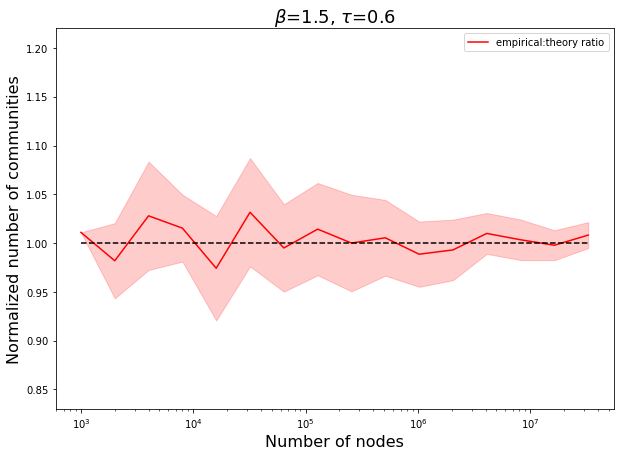

In [13]:
plt.figure(figsize=(10,7))
Y = np.array([i/j for i,j in zip(X,T)])
err = np.array([i/j for i,j in zip(Sx,T)])
plt.semilogx(N, Y, 'r-',label='empirical:theory ratio')
plt.fill_between(N, Y-err, Y+err, color='red', alpha=.2)
plt.hlines(y=1,xmin=min(N),xmax=max(N),colors='black',linestyles='dashed')
plt.title(r"$\beta$=1.5, $\tau$=0.6", fontsize=18)
plt.xlabel('Number of nodes', fontsize=16)
plt.ylabel('Normalized number of communities', fontsize=16)
plt.legend()
## adjust y-range to have same as other plot
plt.ylim((.83,1.22));
#plt.savefig('comm_ratio_tau_75.pdf');

## Figure 5 - Scaled volumes of communies

30 repeats for $n$=1,000, single one for $n$=1,000,000.


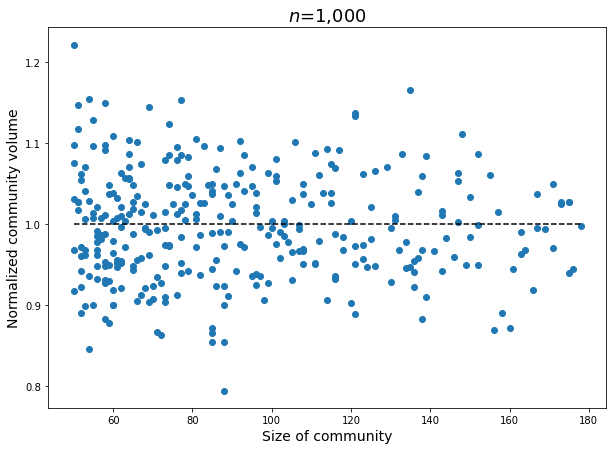

In [14]:
REP = 30
n = 1000

beta = 1.5
s = 50 
tau = 3/4
gamma = 2.5
delta = 5
xi = .2
D = int(np.round(n**0.5))
S = int(np.round(n**tau))

d = 0
t = 0
for k in np.arange(delta,D+1):
    x = rk(k,gamma)
    d += (k*x)
    t += x        
d = d / t
x = []
y = []

for rep in range(REP):
    ## generate graph
    cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
    os.system(cmd+' >/dev/null 2>&1')
    cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000'
    os.system(cmd+' >/dev/null 2>&1')
    cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat xi '+str(xi)+' false false'
    os.system(cmd+' >/dev/null 2>&1')

    g = ig.Graph.Read_Ncol('net.dat',directed=False)
    c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    nc = np.max(gt)+1
    g.vs['comm'] = gt
    g.vs['deg'] = g.degree()    
    for i in range(nc):
        j = [v['deg'] for v in g.vs if v['comm']==i]        
        x.append(len(j))
        y.append(sum(j)/(d*len(j)))

## plot
plt.figure(figsize=(10,7))
plt.plot(x,y,'o')
plt.xlabel('Size of community',fontsize=14)
plt.ylabel('Normalized community volume',fontsize=14)
plt.hlines(y=1,xmin=min(x),xmax=max(x),colors='black',linestyles='dashed')
plt.title(r"$n$=1,000", fontsize=18);
#plt.savefig('comm_vol_1k.pdf');

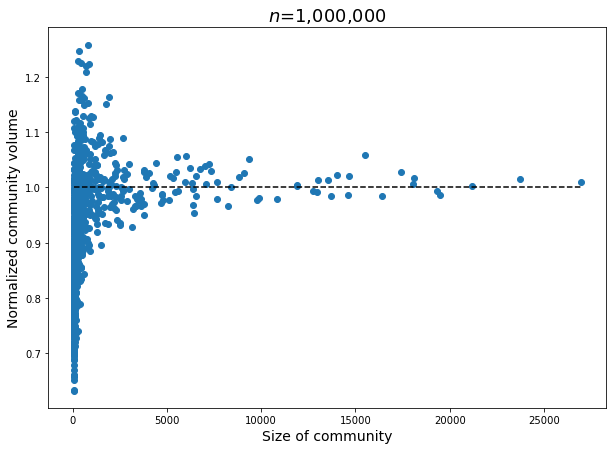

In [15]:
n = 1000000
REP = 1

beta = 1.5
s = 50 
tau = 3/4
gamma = 2.5
delta = 5

xi = .2
D = int(np.round(n**0.5))
S = int(np.round(n**tau))
s = 50

d = 0
t = 0
for k in np.arange(delta,D+1):
    x = rk(k,gamma)
    d += (k*x)
    t += x        
d = d / t

x = []
y = []

for rep in range(REP):

    ## generate graph
    cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
    os.system(cmd+' >/dev/null 2>&1')
    cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000'
    os.system(cmd+' >/dev/null 2>&1')
    cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat xi '+str(xi)+' false false'
    os.system(cmd+' >/dev/null 2>&1')

    g = ig.Graph.Read_Ncol('net.dat',directed=False)
    c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(i['name'])-1]-1 for i in g.vs]
    nc = np.max(gt)+1
    g.vs['comm'] = gt
    g.vs['deg'] = g.degree()
    
    for i in range(nc):
        j = [v['deg'] for v in g.vs if v['comm']==i]        
        x.append(len(j))
        y.append(sum(j)/(d*len(j)))
        
## plot
plt.figure(figsize=(10,7))
plt.plot(x,y,'o')
plt.xlabel('Size of community',fontsize=14)
plt.ylabel('Normalized community volume',fontsize=14)
plt.hlines(y=1,xmin=min(x),xmax=max(x),colors='black',linestyles='dashed')
plt.title(r"$n$=1,000,000", fontsize=18);
#plt.savefig('comm_vol_1M.pdf');

## Figure 6 - Ground truth modularity with varying $n$

We generated plots for $\xi$=0.2 (shown below) and $\xi$=0.7;
with 30 repeats, the code below takes a few hours to run, so it is commented out and we show a plot using the results saved to a local file.

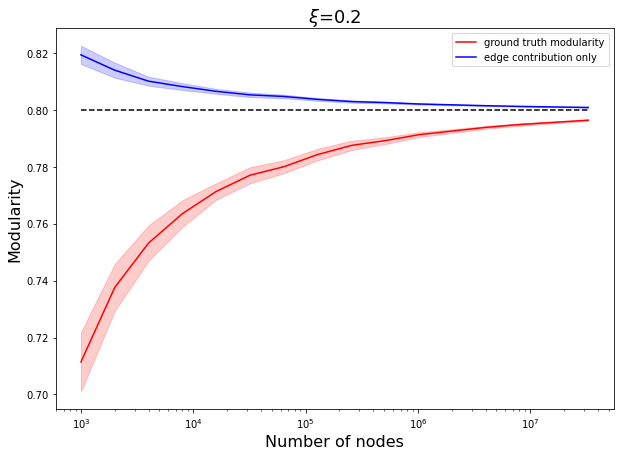

In [16]:
## optional - load results from local file
X, Sx, XX, Sxx = pickle.load( open( "./Data/q_20.pkl", "rb" ) ) # xi = .2

xi = .2
plt.figure(figsize=(10,7))
err = np.array([i for i in Sx])
plt.semilogx(N, X, 'r-',label='ground truth modularity')
plt.fill_between(N, X-err, X+err, color='red', alpha=.2)
err = np.array([i for i in Sxx])
plt.semilogx(N, XX, 'b-',label='edge contribution only')
plt.fill_between(N, XX-err, XX+err, color='blue', alpha=.2)
plt.hlines(y=1-xi,xmin=min(N),xmax=max(N),colors='black',linestyles='dashed')
plt.title(r"$\xi$=0.2", fontsize=18)
plt.xlabel('Number of nodes', fontsize=16)
plt.ylabel('Modularity', fontsize=16)
plt.legend();
#plt.savefig('q_20.pdf');

## Figure 7&8 and Table 2 - Ground truth and ECG modularity with varying $\xi$

We generated plots for $n$=1,000 (shown below) and $n$=1,000,000.

With 30 repeats, the code for $n=1,000$ takes about 12 minutes; we show the result for 10 repeats below.

With $n=1,000,000$, this experiment takes several hours; we ran it on several CPUs.


In [17]:
# n = 1000 or 1000000
n = 1000 
REP = 10 ## we used 30 in the paper

beta = 1.5
s = 50 
tau = 3/4
delta = 5
gamma = 2.5

# init
q_gt = []
Sq_gt = []
ec_gt = []
Sec_gt = []
q_ecg = []
Sq_ecg = []
ec_ecg = []
Sec_ecg = []
sim_ari = []
sim_ami = []

XI = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
S = int(np.round(n**tau))
D = int(np.round(n**0.5))

for xi in XI:
    z_ecg = []
    zz_ecg = []
    z_gt = []
    zz_gt = []
    ari = []
    ami = []
    
    for i in range(REP):
        ## generate graph
        cmd = 'julia '+abcd_path+'deg_sampler.jl deg.dat '+str(gamma)+' '+str(delta)+' '+str(D)+' '+str(n)+' 1000'
        os.system(cmd+' >/dev/null 2>&1')
        cmd = 'julia '+abcd_path+'com_sampler.jl cs.dat '+str(beta)+' '+str(s)+' '+str(S)+' '+str(n)+' 1000'
        os.system(cmd+' >/dev/null 2>&1')
        cmd = 'julia '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat xi '+str(xi)+' false false'
        os.system(cmd+' >/dev/null 2>&1')

        g = ig.Graph.Read_Ncol('net.dat',directed=False)
        c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
        
        ## ECG
        gt = [c[int(i['name'])-1]-1 for i in g.vs]
        g.vs['gt'] = gt

        ecg = g.community_ecg().membership
        g.vs['ecg'] = ecg
        
        ## 
        z_ecg.append(g.modularity(ecg))
        zz_ecg.append(sum([g.vs[e.tuple[0]]['ecg'] == g.vs[e.tuple[1]]['ecg'] for e in g.es])/g.ecount())
        z_gt.append(g.modularity(gt))
        zz_gt.append(sum([g.vs[e.tuple[0]]['gt'] == g.vs[e.tuple[1]]['gt'] for e in g.es])/g.ecount())
        ami.append(AMI(g.vs['gt'] ,g.vs['ecg']))
        ari.append(ARI(g.vs['gt'] ,g.vs['ecg']))

    q_gt.append(np.mean(z_gt))
    Sq_gt.append(np.std(z_gt))
    ec_gt.append(np.mean(zz_gt))
    Sec_gt.append(np.std(zz_gt))
    q_ecg.append(np.mean(z_ecg))
    Sq_ecg.append(np.std(z_ecg))
    ec_ecg.append(np.mean(zz_ecg))
    Sec_ecg.append(np.std(zz_ecg))
    sim_ari.append(np.mean(ari))
    sim_ami.append(np.mean(ami))

## optional - save results to local file
#pickle.dump( (q_gt,Sq_gt,ec_gt,Sec_gt,q_ecg,Sq_ecg,ec_ecg,Sec_ecg,sim_ari,sim_ami), 
#            open( "./Data/q_xis_1000_both.pkl", "wb" ) )


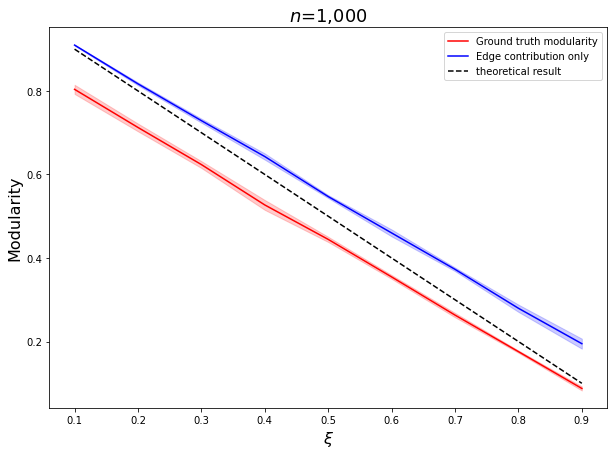

In [18]:
## Figure 7 - ground truth
plt.figure(figsize=(10,7))
err = np.array([i for i in Sq_gt])
plt.plot(XI, q_gt, 'r-',label='Ground truth modularity')
plt.fill_between(XI, q_gt-err, q_gt+err, color='red', alpha=.2)
err = np.array([i for i in Sec_gt])
plt.plot(XI, ec_gt, 'b-',label='Edge contribution only')
plt.fill_between(XI, ec_gt-err, ec_gt+err, color='blue', alpha=.2)
plt.plot((.1,.9),(.9,.1),'k--',label='theoretical result')
plt.title(r"$n$=1,000", fontsize=18)
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel('Modularity', fontsize=16)
plt.legend();
#plt.savefig('q_xis_1000.pdf');

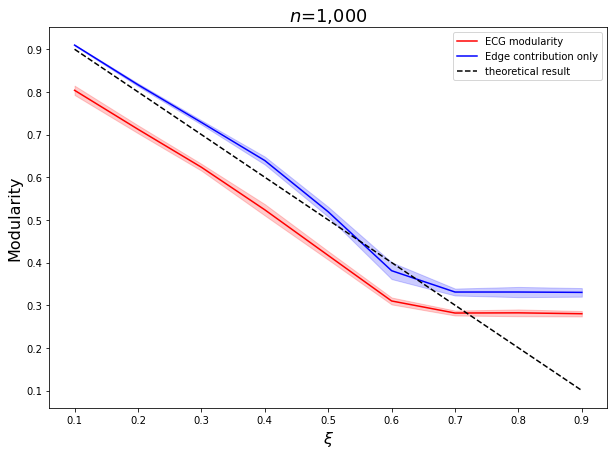

In [19]:
## Figure 8 - ECG
plt.figure(figsize=(10,7))
err = np.array([i for i in Sq_ecg])
plt.plot(XI, q_ecg, 'r-',label='ECG modularity')
plt.fill_between(XI, q_ecg-err, q_ecg+err, color='red', alpha=.2)
err = np.array([i for i in Sec_ecg])
plt.plot(XI, ec_ecg, 'b-',label='Edge contribution only')
plt.fill_between(XI, ec_ecg-err, ec_ecg+err, color='blue', alpha=.2)
plt.plot((.1,.9),(.9,.1),'k--',label='theoretical result')
plt.title(r"$n$=1,000", fontsize=18)
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel('Modularity', fontsize=16)
plt.legend();
#plt.savefig('q_xis_1000_ecg.pdf');

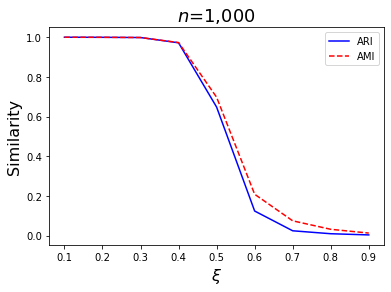

In [20]:
## AMI/ARI
plt.plot(XI, sim_ari, 'b-',label='ARI')
plt.plot(XI, sim_ami, 'r--',label='AMI')
plt.title(r"$n$=1,000", fontsize=18)
plt.xlabel(r"$\xi$", fontsize=16)
plt.ylabel('Similarity', fontsize=16)
plt.legend();


In [21]:
## Table 2
df = pd.DataFrame(np.array([XI,q_gt,q_ecg,sim_ami,sim_ari]).transpose(),columns=['xi','gt','ecg','ami','ari'])
df

,xi,gt,ecg,ami,ari
0,0.1,0.803756,0.803756,1.000000,1.000000
1,0.2,0.712490,0.712392,0.999701,0.999663
2,0.3,0.623655,0.623409,0.998543,0.998586
3,0.4,0.526994,0.523596,0.973288,0.971992
4,0.5,0.444532,0.416606,0.697692,0.647980
5,0.6,0.354675,0.309886,0.208449,0.123891
6,0.7,0.263295,0.281614,0.074478,0.024235
7,0.8,0.175809,0.282067,0.031731,0.009415
8,0.9,0.087645,0.279959,0.012721,0.003412


## Results for (19), (20)

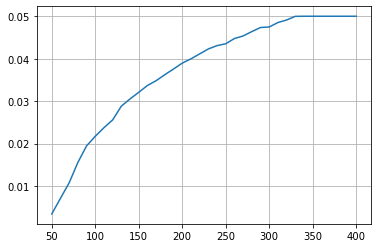

In [22]:
def c(a,b):
    return (a * (b - 2 * np.sqrt(b - 1)) / 2) / (a*b + b - 1) - (b - 1) / (a*b + b - 1) - 0.011
L = []
for delta in np.arange(50,401,10):
    best = np.iinfo(np.int64).min
    best_a = -1
    best_b = -1
    for a in np.arange(1,140):
        for b in np.arange(3,1+int(np.floor(delta/a))):
            if a*b<delta:
                candidate = min(1 - a * b / delta, c(a, b) / 4, 1/20)
                if candidate > best:
                    best = candidate
                    best_a = a
                    best_b = b
    L.append([delta, best, best_a, best_b])
D = pd.DataFrame(L, columns=['delta','best','a','b'])
plt.plot(D['delta'],D['best'])
plt.grid();


In [23]:
D[D['delta']<=120]

,delta,best,a,b
0,50,0.003403,7,7
1,60,0.007090,7,8
2,70,0.010750,8,8
3,80,0.015538,7,11
4,90,0.019448,8,11
5,100,0.021706,8,12
6,110,0.023731,8,13
7,120,0.025561,8,14
